# _P. litorale_ in the context of other genomes

### 2024-09-10

Here we will explore how the _P. litorale_ genome stacks up in comparison to other genomes of
comparable organisms. We will mostly be looking at other chelicerates and arthropods in general.

We start by finding the data. We used the NCBI Datasets portal, and from the "Genomes" section we
[searched for "arthropoda"](https://www.ncbi.nlm.nih.gov/datasets/genome/?taxon=6656) (as of
2024-09-10). We filtered to exclude atypical genomes, metagenome-assembled genomes (MAGs), and
genomes from large multi-isolate projects and downloaded the resulting table into a TSV file,
`arthropoda.tsv`.

We will read the table with Pandas and plot some aspects of the data.

In [1]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

First we can drop some of the columns which carry little information for our purposes.

In [2]:
cmyk = ["gold", "m", "k", "c"]
cmyk_mid = ["k", "k", "k", "k"]

In [3]:
arthropoda = pd.read_csv('./genomic_context/arthropoda.tsv', sep='\t')
arthropoda.drop(columns=['Organism Infraspecific Names Breed',
       'Organism Infraspecific Names Strain',
       'Organism Infraspecific Names Cultivar',
       'Organism Infraspecific Names Ecotype',
       'Organism Infraspecific Names Isolate',
       'Organism Infraspecific Names Sex',], inplace=True)

In [4]:
arthropoda.columns

Index(['Assembly Accession', 'Assembly Name', 'Organism Name',
       'Organism Taxonomic ID', 'ANI Check status', 'Annotation Name',
       'Assembly Stats Total Sequence Length',
       'Assembly Stats Total Number of Chromosomes', 'Assembly Level',
       'Assembly Release Date', 'WGS project accession',
       'Assembly Stats Contig N50', 'Assembly Stats Scaffold N50',
       'Assembly Stats Number of Scaffolds', 'Annotation BUSCO Complete ',
       'Annotation BUSCO Single Copy ', 'Annotation BUSCO Duplicated ',
       'Annotation BUSCO Fragmented ', 'Annotation BUSCO Missing ',
       'Annotation BUSCO Lineage ', 'Annotation Count Gene Total',
       'Annotation Count Gene Protein-coding'],
      dtype='object')

All the columns left now are potentially informative. We should start by keeping the "best" assembly
per species, since popular taxa like _Drosophila_ have many assemblies. What is the "best" assembly
though?

- first we should filter by the level of the assembly (complete > chromosome > scaffold > contig)
- some assemblies are produced by large sequencing consortia; those often are not annotated. If
available, we would prefer annotated assemblies, since they might have other statistics available,
like gene number or BUSCO completeness.
- if there are still multiple assemblies after these filters, we should prefer the one that reports
additional statistics, like gene number or BUSCO completeness.
- if there are still multiple assemblies, we should prefer the most recent one.

In [5]:
def best_assembly(df):
    filtered = df
    # first filter for the highest level of contiguity
    if (filtered['Assembly Level'] == 'Complete').any():
        filtered = filtered[filtered['Assembly Level'] == 'Complete']
    if (filtered['Assembly Level'] == 'Chromosome').any():
        filtered = filtered[filtered['Assembly Level'] == 'Chromosome']
    elif (filtered['Assembly Level'] == 'Scaffold').any():
        filtered = filtered[filtered['Assembly Level'] == 'Scaffold']
    # next, filter for the annotated ones, as those are more likely to be of higher quality
    if ~filtered['Annotation Name'].isna().any():
        filtered = filtered[~filtered['Annotation Name'].isna()]
    # next, filter for entries that have annotations like BUSCO scores or gene counts
    annotation_columns = ["Annotation BUSCO Complete ", "Annotation Count Gene Total"]
    annotated = (~filtered[annotation_columns].isna()).sum(axis=1)
    if (annotated > 0).any():
        filtered = filtered[annotated > 0]
    # finally, sort by date and drop duplicates to keep the most recent one
    filtered = filtered.sort_values('Assembly Release Date', ascending=False).drop_duplicates('Organism Name')
    return filtered

actually choose the best assembly per species:

In [6]:
modern = arthropoda.groupby('Organism Name').apply(best_assembly)

/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/ipykernel_19374/2782223938.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  modern = arthropoda.groupby('Organism Name').apply(best_assembly)


In [7]:
modern.index = modern.index.droplevel(1)

At this point we would like to assign a taxonomic level to each assembly. For that, we can use the
NCBI Taxonomy website, which can map species IDs to their taxonomic lineage. Extract the tax IDs
first...

In [8]:
modern['Organism Taxonomic ID'].to_csv('./genomic_context/modern_taxids.txt', index=False, header=False)

and now go to NCBI and use the [Taxonomy name/id Status Report
Page](https://www.ncbi.nlm.nih.gov/Taxonomy/TaxIdentifier/tax_identifier.cgi). Use the
modern_taxids.txt file as input. It is important to ask for the "full taxid lineage" and click on
"Save in file"; this will download the result as a human-readable file. We can use Pandas' powerful
parsing capabilities to extract the information we need.

Essentially, we will scan each line to find the subphylum IDs and translate them to their name - one
of Hexapoda (mostly insects, in our case), Chelicerata, Crustacea, or Myriapoda.

In [9]:
taxonomy = pd.read_csv('./genomic_context/tax_report.txt', sep="\t\|\t", skiprows=1, engine='python')
lookup = {
    '6960': 'Hexapoda',
    '6843': 'Chelicerata',
    '6657': 'Crustacea',
    '61985': 'Myriapoda',
}

def assign_lineage(x, lookup):
    for k, v in lookup.items():
        if k in x:
            return v
    return 'Other'

taxonomy['subphylum'] = taxonomy['lineage'].apply(lambda x: assign_lineage(x, lookup)).astype('category')
taxonomy['subphylum'] = taxonomy['subphylum'].cat.set_categories(['Hexapoda', 'Chelicerata', 'Myriapoda', 'Crustacea'], ordered=True)

append the mapping to the assembly table:

In [10]:
modern = modern.join(taxonomy.set_index('taxid')['subphylum'], on='Organism Taxonomic ID')

let's test that it worked, and also see what we're dealing with:

In [11]:
modern['subphylum'].value_counts()

subphylum
Hexapoda       3438
Chelicerata     179
Crustacea       132
Myriapoda        53
Name: count, dtype: int64

as expected, the vast majority of (published and indexed) genomes come from insects. Still, there is
quite a lot of data for other subphyla, so we should get a robust comparison.

Let's save the _Pycnogonum_ data in comparable form:

In [12]:
pycnogonum = {
    'Assembly Accession':'-',
    'Assembly Name':'Plit_v1.0',
    'Organism Name':'Pycnogonum litorale',
    'Organism Taxonomic ID':'261975',
    'Annotation Name':'-',
    'Assembly Stats Total Sequence Length':471606659,
    'Assembly Stats Total Number of Chromosomes':57,
    'Assembly Level':'Chromosome',
    'Assembly Release Date':'2024-10-01',
    'WGS project accession':'-',
    'Assembly Stats Contig N50':522825,
    'Assembly Stats Scaffold N50':7968359,
    'Assembly Stats Number of Scaffolds':10257,
    'Annotation BUSCO Complete ':96.7,
    'Annotation BUSCO Single Copy ':91.0,
    'Annotation BUSCO Duplicated ':5.7,
    'Annotation BUSCO Fragmented ':1.6,
    'Annotation BUSCO Missing ':1.7,
    'Annotation BUSCO Lineage ':'metazoa_odb10',
    'Annotation Count Gene Total':15372,
    'Annotation Count Gene Protein-coding':15372,
    'CheckM contamination':'-',
    'subphylum':'Chelicerata',
    'repeat%': 61.05
}

To make the comparison more relevant we will also filter the data to (very) recent genomes. There is
little sense in comparing to genomes assembled in the pre-long read era.

In [13]:
recent = modern['Assembly Release Date'].astype('datetime64[ns]') > '2021'

First we will plot the number of chromosomes. Going off the recent chelicerate literature, _P.
litorale_ seems to have a rather high number of chromosomes for its subphylum. How is it in the
phylum level? Is the number abnormal or is it within the range of other arthropods?

In [14]:
cmyk = ["gold", "m", "k", "c"]
cmyk_mid = ["goldenrod", "darkorchid", "k", "steelblue"]

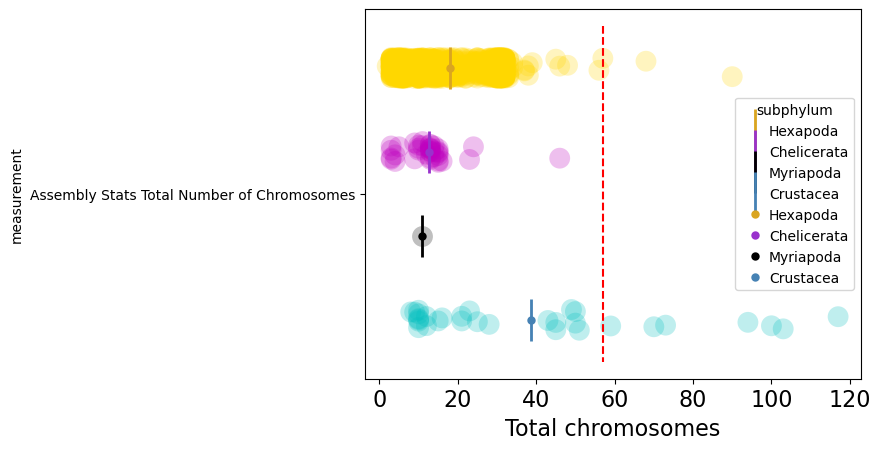

In [15]:
f, ax = plt.subplots()
# sns.despine(left=True)

keep = [
    'Assembly Stats Total Number of Chromosomes',
    'subphylum',
]
melted = modern[recent][keep].melt(id_vars="subphylum", var_name="measurement")

# Show each observation with a scatterplot
sns.stripplot(
    data=melted, x="value", y="measurement", hue="subphylum", palette=cmyk,
    dodge=True, alpha=.25, zorder=1, legend=False, ax=ax, s=15,
)
# ax.set_xlim(0, 1e10)

# Show the means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(
    data=melted, x="value", y="measurement", hue="subphylum",
    dodge=.8 - .8 / 4, palette=cmyk_mid, errorbar=None,
    markers="|", markersize=30, linestyle="none",
)
sns.pointplot(
    data=melted, x="value", y="measurement", hue="subphylum",
    dodge=.8 - .8 / 4, palette=cmyk_mid, errorbar=None,
    markersize=4, linestyle="none",
)


ax.vlines(pycnogonum['Assembly Stats Total Number of Chromosomes'], -0.4, 0.4, colors='r', linestyles='dashed')
# ax.set_xlim(0, 50000)
ax.tick_params(axis='x', labelsize=16)
ax.set_xlabel('Total chromosomes', fontsize=16)

# Improve the legend
sns.move_legend(
    ax, loc="right", ncol=1, frameon=True, columnspacing=1, handletextpad=0,
)
plt.savefig('./figs/chromosomes.svg')
# plt.close()

While _Pycnogonum_ is a definite outlier for chelicerates, which so far seem to have the least
chromosomes among the phylum (unfortunately not a lot of data for myriapods). It seems, however,
that 57 chromosomes is fine for crustaceans, and there are even insects with more chromosomes. If we
take into account how good the omni-C map looks, it seems that the total chromosome number is
reasonable, and the only (minimal) change that we could anticipate here might come from sex
chromosomes (female speciment for DNA extraction; male specimen for omni-C).

Next up, we should look at the completeness of the genome, using BUSCO scores as a proxy. This is
tricky, since the BUSCO database is biased towards insects, and also the assemblies have been
benchmarked with different subsets of the database. Still, it is a useful, if approximate,
comparison.

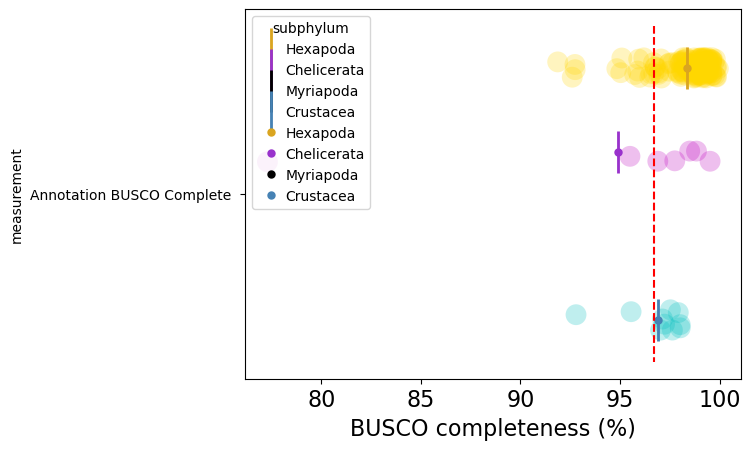

In [16]:
f, ax = plt.subplots()
# sns.despine(left=True)

keep = [
    'Annotation BUSCO Complete ',
    'subphylum',
]
melted = modern[recent][keep].melt(id_vars="subphylum", var_name="measurement")
melted['value'] = melted['value'] * 100
# Show each observation with a scatterplot
sns.stripplot(
    data=melted, x="value", y="measurement", hue="subphylum", palette=cmyk,
    dodge=True, alpha=.25, zorder=1, legend=False, ax=ax, s=15
)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(
    data=melted, x="value", y="measurement", hue="subphylum",
    dodge=.8 - .8 / 4, palette=cmyk_mid, errorbar=None,
    markers="|", markersize=30, linestyle="none",
)
sns.pointplot(
    data=melted, x="value", y="measurement", hue="subphylum",
    dodge=.8 - .8 / 4, palette=cmyk_mid, errorbar=None,
    markersize=4, linestyle="none",
)

# ax.axhline(0.4, color='black')
# ax.axvline(color='black')
ax.vlines(pycnogonum['Annotation BUSCO Complete '], -0.4, 0.4, colors='r', linestyles='dashed')
ax.tick_params(axis='x', labelsize=16)
ax.set_xlabel('BUSCO completeness (%)', fontsize=16)

# Improve the legend
sns.move_legend(ax, loc="upper left", ncol=1, frameon=True, columnspacing=1, handletextpad=0)

plt.savefig('./figs/busco.svg')

Insects perform better, as expected. However, _Pycnogonum_ looks like par for the course for
non-insect genomes, even if we exclude the outliers.

Next up, we should look at the gene number. As a reminder, we performed several rounds of annotation
for _Pycnogonum_, using Iso-seq data, BRAKER3 (twice), and even _de novo_ transcriptome assemblies,
as the gene numbers we obtained felt low, and manual inspection of the transcriptome mapping showed
multiple loci that looked like they had intron-exon structures. If we were right, _Pycnogonum_'s
total gene numbers should be above the parasitic taxa in the _Acariformes_/_Parasitiformes_ and
around the gene numbers of other chelicerates.

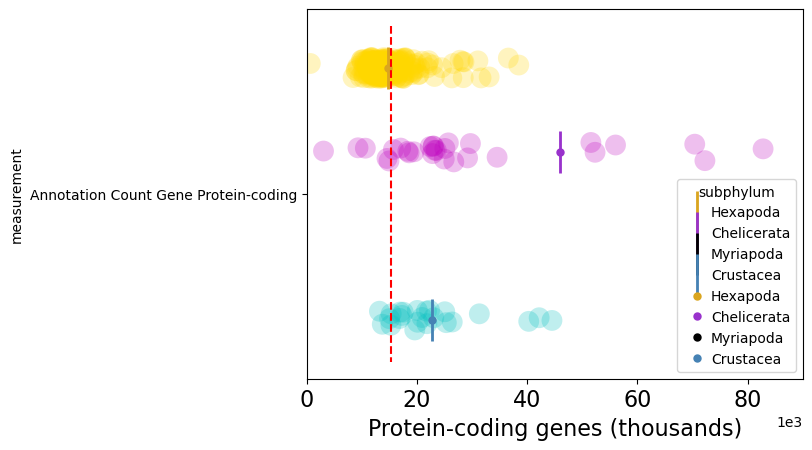

In [17]:
f, ax = plt.subplots()
# sns.despine(left=True)

keep = [
    'Annotation Count Gene Protein-coding',
    'subphylum',
]
melted = modern[recent][keep].melt(id_vars="subphylum", var_name="measurement")

# Show each observation with a scatterplot
sns.stripplot(
    data=melted, x="value", y="measurement", hue="subphylum", palette=cmyk,
    dodge=True, alpha=.25, zorder=1, legend=False, ax=ax, s=15
)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(
    data=melted, x="value", y="measurement", hue="subphylum",
    dodge=.8 - .8 / 4, palette=cmyk_mid, errorbar=None,
    markers="|", markersize=30, linestyle="none",
)
sns.pointplot(
    data=melted, x="value", y="measurement", hue="subphylum",
    dodge=.8 - .8 / 4, palette=cmyk_mid, errorbar=None,
    markersize=4, linestyle="none",
)

# ax.axhline(0.4, color='black')
# ax.axvline(color='black')
ax.vlines(pycnogonum['Annotation Count Gene Protein-coding'], -0.4, 0.4, colors='r', linestyles='dashed')
ax.set_xlim(0, 90000)
ax.tick_params(axis='x', labelsize=16)
ax.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
ax.set_xlabel('Protein-coding genes (thousands)', fontsize=16)

# Improve the legend
sns.move_legend(ax, loc="lower right", ncol=1, frameon=True, columnspacing=1, handletextpad=0)
plt.savefig('./figs/genes.svg')

Despite the smaller average size of chelicerate genomes, most published assemblies have more
predicted genes than _P. litorale_. At least the gene number, even if it is a conservative estimate,
is not an outlier, and seems to be within normal limits for arthropods. Again, the high BUSCO score
of the predicted peptides extracted from the genome suggests that we are on solid ground.

Finally, we should look at the size of the genome. Ideally we would have experimental data (like
Feulgen stainings) to look at this, but we can use the assembly size as a proxy.

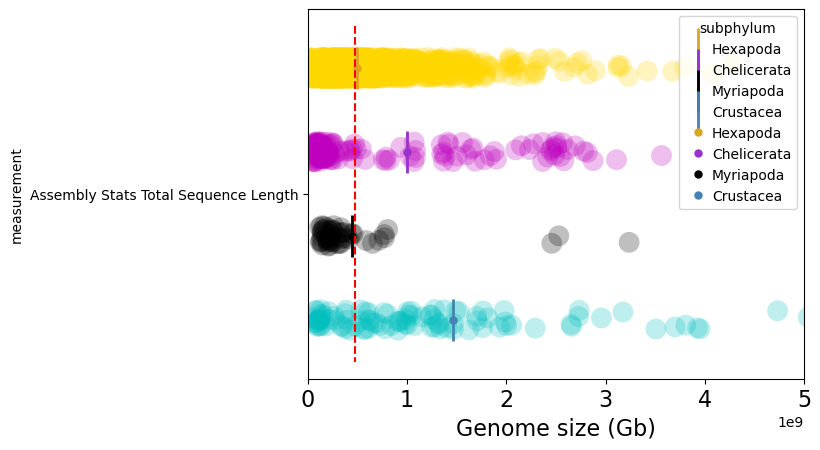

In [18]:
f, ax = plt.subplots()
# sns.despine(left=True)

keep = [
    'Assembly Stats Total Sequence Length',
    'subphylum',
]
melted = modern[recent][keep].melt(id_vars="subphylum", var_name="measurement")

# Show each observation with a scatterplot
sns.stripplot(
    data=melted, x="value", y="measurement", hue="subphylum", palette=cmyk,
    dodge=True, alpha=.25, zorder=1, legend=False, ax=ax, s=15
)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(
    data=melted, x="value", y="measurement", hue="subphylum",
    dodge=.8 - .8 / 4, palette=cmyk_mid, errorbar=None,
    markers="|", markersize=30, linestyle="none",
)
sns.pointplot(
    data=melted, x="value", y="measurement", hue="subphylum",
    dodge=.8 - .8 / 4, palette=cmyk_mid, errorbar=None,
    markersize=4, linestyle="none",
)

# ax.axhline(0.4, color='black')
# ax.axvline(color='black')
ax.vlines(pycnogonum['Assembly Stats Total Sequence Length'], -0.4, 0.4, colors='r', linestyles='dashed')
ax.set_xlim(0, 5e9)
ax.tick_params(axis='x', labelsize=16)
ax.set_xlabel('Genome size (Gb)', fontsize=16)

# Improve the legend
sns.move_legend(ax, loc="upper right", ncol=1, frameon=True, columnspacing=1, handletextpad=0)
plt.savefig('./figs/length.svg')

_Pycnogonum_ is on the shorter side of chelicerate genomes, but not an outlier by any means. It is
reassuring that myriapods (and even insects!) have such similar genome sizes. Until more pycnogonid
genomes are sequenced, however, it is difficult to say how typical _P. litorale_ is in this regard.

Another detail that was a bit surprising in the genome annotation was the high repeat content. We
annotated _P, litorale_ with RepeatModeler and RepeatMasker, and came out at ~60% repetitive
content. We wanted to put that in the context of chelicerates/other arthropods. We used the work of
[Sheffer _et al._](https://academic.oup.com/gigascience/article/10/1/giaa148/6067174), who profiled
the repeat content of 19 arachnids, 5 insects and one myriapod.

In [19]:
repeats = pd.read_csv('./genomic_context/total_repeats.tsv', sep='\t', header=0)
repeats = repeats.drop(columns='source')
repeats.set_index('species', inplace=True)
repeats.index.name = 'Organism Name'

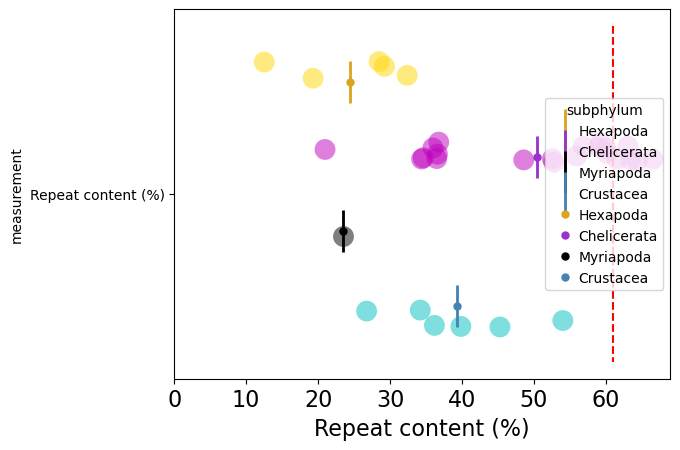

In [20]:
f, ax = plt.subplots()
# sns.despine(left=True)

melted = repeats[['subphylum', 'repeat%']].copy()
melted['measurement'] = 'Repeat content (%)'

# Show each observation with a scatterplot
sns.stripplot(
    data=melted, x="repeat%", y="measurement", hue="subphylum", palette=cmyk,
    dodge=True, alpha=.5, zorder=1, legend=False, ax=ax, s=15
)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(
    data=melted, x="repeat%", y="measurement", hue="subphylum",
    dodge=.8 - .8 / 3, palette=cmyk_mid, errorbar=None,
    markers="|", markersize=30, linestyle="none",
)
sns.pointplot(
    data=melted, x="repeat%", y="measurement", hue="subphylum",
    dodge=.8 - .8 / 3, palette=cmyk_mid, errorbar=None,
    markersize=4, linestyle="none",
)

# ax.axhline(0.4, color='black')
# ax.axvline(color='black')
ax.vlines(pycnogonum['repeat%'], -0.4, 0.4, colors='r', linestyles='dashed')
# ax.set_xlim(0, 5e9)
ax.tick_params(axis='x', labelsize=16)
ax.set_xlabel('Repeat content (%)', fontsize=16)
ax.set_xlim(0, 69)

# Improve the legend
sns.move_legend(ax, loc="center right", ncol=1, frameon=True, columnspacing=1, handletextpad=0)
plt.savefig('./figs/total_repeats.svg')

In [21]:
merged = modern.join(repeats['repeat%'], how='inner')

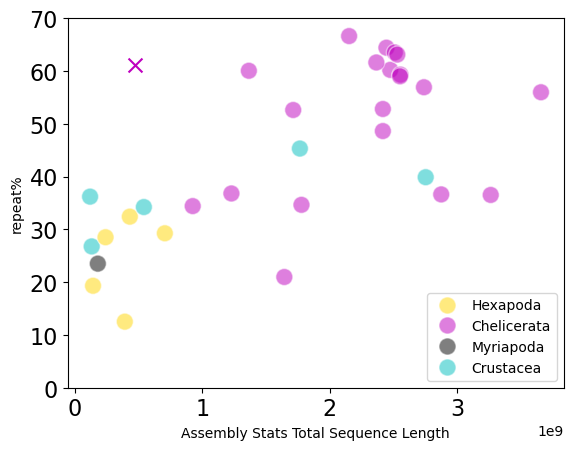

In [22]:
fig, ax = plt.subplots()
sns.scatterplot(merged, x='Assembly Stats Total Sequence Length', y='repeat%', hue='subphylum', ax=ax, palette=cmyk, alpha=0.5, s=150)
ax.scatter(pycnogonum['Assembly Stats Total Sequence Length'], pycnogonum['repeat%'], color='m', marker='x', s=100)
ax.legend(loc='lower right')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim(0, 70)

plt.savefig('./figs/length_vs_repeats.svg')

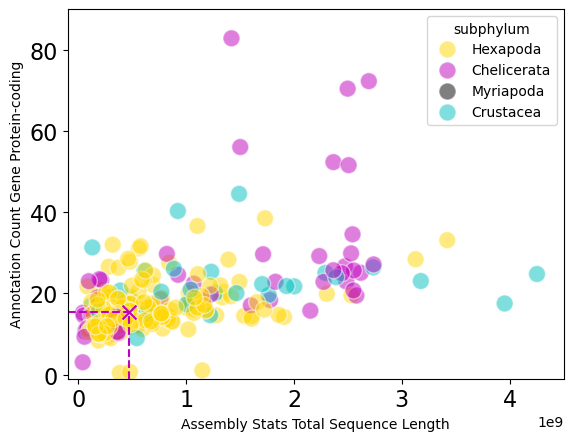

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(modern, x='Assembly Stats Total Sequence Length', y='Annotation Count Gene Protein-coding', hue='subphylum', ax=ax, alpha=0.5, palette=cmyk, s=150)
ax.set_xlim(-1e8, 4.5e9)
ax.set_ylim(-1000, 90000)
ax.scatter(pycnogonum['Assembly Stats Total Sequence Length'], pycnogonum['Annotation Count Gene Protein-coding'], color='m', marker='x', s=100)
ax.hlines(xmin=-1e8, y=pycnogonum['Annotation Count Gene Protein-coding'], xmax=pycnogonum['Assembly Stats Total Sequence Length'], linestyles='dashed', colors='m')
ax.vlines(ymin=-1000, ymax=pycnogonum['Annotation Count Gene Protein-coding'], x=pycnogonum['Assembly Stats Total Sequence Length'], linestyles='dashed', colors='m')
# ax.legend(loc='lower right')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_yticks([0, 20000, 40000, 60000, 80000], labels=['0', '20', '40', '60', '80'])

plt.savefig('./figs/length_vs_protein.svg')

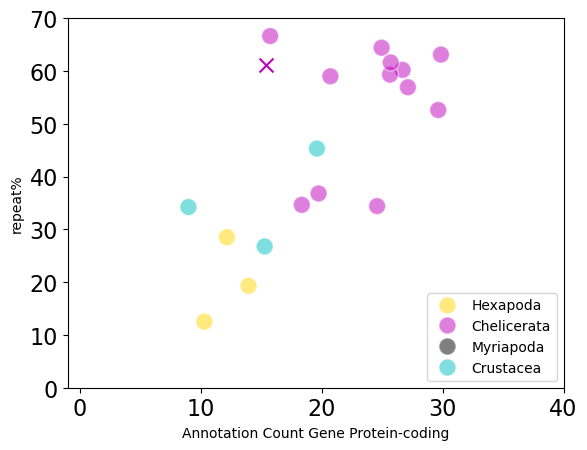

In [24]:
fig, ax = plt.subplots()
sns.scatterplot(merged, x='Annotation Count Gene Protein-coding', y='repeat%', hue='subphylum', ax=ax, palette=cmyk, alpha=0.5, s=150)
# ax.set_xlim(-1e8, 4.5e9)
ax.set_xlim(-1000, 40000)
ax.scatter(pycnogonum['Annotation Count Gene Protein-coding'], pycnogonum['repeat%'], color='m', marker='x', s=100)
# ax.hlines(xmin=-1e8, y=pycnogonum['Annotation Count Gene Protein-coding'], xmax=pycnogonum['Assembly Stats Total Sequence Length'], linestyles='dashed', colors='k')
# ax.vlines(ymin=-1000, ymax=pycnogonum['Annotation Count Gene Protein-coding'], x=pycnogonum['Assembly Stats Total Sequence Length'], linestyles='dashed', colors='k')
ax.legend(loc='lower right')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim(0, 70)
ax.set_xticks([0, 10000, 20000, 30000, 40000], labels=['0', '10', '20', '30', '40'])

plt.savefig('./figs/protein_vs_repeat.svg')

While Pycnogonum has a high percentage of repetitive content, it is not an outlier among
chelicerates, though it is on the higher end. It is interesting to note that insects, with their
overall shorter genomes, also have clearly lower repeat content.

RepeatMasker also provides a breakdown of the repeat content by class. We looked at recent genome
assembly papers for chelicerates and manually extracted information on repeat content:

- 11 spiders (Araneae) from [Sheffer _et al._](https://academic.oup.com/gigascience/article/10/1/giaa148/6067174)
- the spider _Uloborus diversus_ from [Miller _et al._](https://academic.oup.com/gigascience/article/doi/10.1093/gigascience/giad002/7033993)
- The desert scorpion _Hardurus arizonensis_ from [Bryant _et al._](https://academic.oup.com/gbe/article/16/5/evae097/7664275)
- _Limulus polyphemus_ from [Shingate _et al._](https://www.nature.com/articles/s41467-020-16180-1)
- two more horseshoe crabs from [Nong _et al._](https://www.nature.com/articles/s42003-020-01637-2)
- the model tick _Ixodes scapularis_ from [Nuss _et al._](https://www.life-science-alliance.org/content/6/12/e202302109)
- the free-living oribatid mite _Archegozetes longisetosus_ from [Brückner _et al._](https://www1.montpellier.inrae.fr/CBGP/acarologia/article.php?id=4528)

In [25]:
repeat_makeup = pd.read_csv('./genomic_context/araneae.tsv', sep='\t', header=None)
repeat_makeup.columns = repeat_makeup.iloc[0]
repeat_makeup.drop(0, inplace=True)

In [26]:
# drop the sources
no_total = repeat_makeup.drop(columns='source')

In [27]:
melted = no_total.melt(id_vars='Species')
# since we read this in as mixed type, the value column is an object-type
# we need to convert it to a float
melted['value'] = melted['value'].astype(float)

In [28]:
melted.columns = ['Species', 'Repeat element', 'Proportion of the genome (%)']

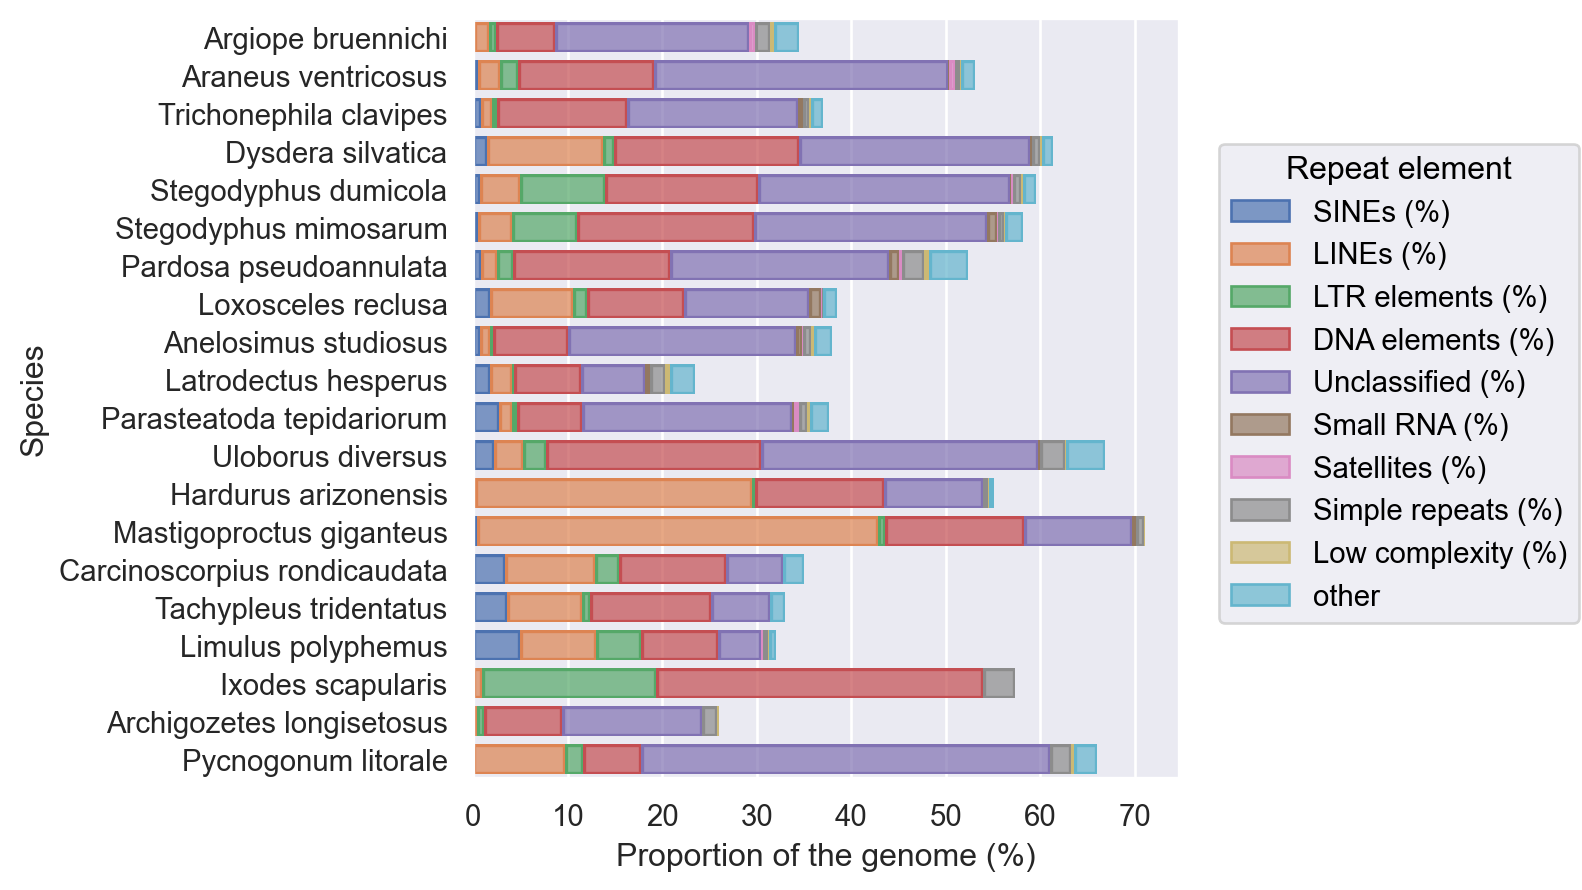

In [29]:
p = so.Plot(melted, x='Proportion of the genome (%)', y='Species', color='Repeat element').add(so.Bar(), so.Stack())
p.save('./figs/repeat_makeup.svg', bbox_inches=Bbox.from_extents(0, 0, 10, 7))

Again, while _Pycnogonum_ has a high repeat content, it is not an outlier among chelicerates. The
high proportion of unknown/unclassified repeats is also not unique, and is probably best explained
by the lack of reference repeat libraries for chelicerates.

An interesting detail is that the repeat content seems to be very diverse in the different taxa,
with very little consistency (except maybe for the horseshoe crabs). This is partly caused by the
fact that not all authors report repeats in the same way, making it less straightforward to compare.
This was particularly true for the _Ixodes_ genome.

## Conclusion

_Pycnogonum_ does not seem to be an outlier in any of the metrics we looked at. Until more
pycnogonid genomes are available it is difficult to say how typical the _P. litorale_ genome is, but
it seems to fit well within the chelicerate/arthropod context.